La red que vamos a construir toma datos de un dataset que contiene toda la información genética que Manu Sporny logró recabar usando varias marcas genéticas. Con base en esas marcas genéticas vamos a clasificar cada una en diferentes genotipos.

In [1]:
import tensorflow as tf
import torch as pt
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt 
import random

# leemos el archivo

f = open('ManuSporny-genome.txt', 'r')
all_lines = f.read().split('\n')
lines_without_comments = list(filter(lambda x: len(x) > 0 and x[0] != '#', all_lines))
lines_to_rows = list(map(lambda x: x.split('\t'), lines_without_comments))

El conjunto de datos está dividido en 3 columnas de datos genéticos; rsid, chromosoma, posición. Y una última columna que es la clasificación del genotipo de cada renglón.

In [2]:
# clasificamos las entradas y salidas de la red

chromosome = [row[1] for row in lines_to_rows]

genotypes = [row[3] for row in lines_to_rows]

Aunque todos los datos son números, la red puede llegar a confundirse y no encontrar ninguna relación entre estos, así que, como será una red clasificadora, debemos separar el conjunto usando one-hot-encoding.

In [3]:
# obtenemos todas las clases

chromosome_classes = list(set(chromosome))

genotypes_classes = list(set(genotypes))

# aplicamos one-hot-encoding

chromosome_indexes = [i for i,_ in enumerate(chromosome_classes)]

chromosome_one_hot = tf.one_hot(chromosome_indexes, len(chromosome_indexes), dtype=float)

genotypes_indexes = [i for i,_ in enumerate(genotypes_classes)]

genotypes_one_hot = tf.one_hot(genotypes_indexes, len(genotypes_classes), dtype=float)

# emparejamos las clases con su one hot

chromosome_match = list(zip(chromosome_classes, chromosome_one_hot))
genotypes_match = list(zip(genotypes_classes, genotypes_one_hot))

Ahora, debemos unir todos los datos y preparar las entradas y salidasd de la red y generar los conjuntos de prueba y entrenamiento.

In [4]:
# construimos las matrices de entrada

dataset = list()

for r, c, p, g in lines_to_rows:
  for chromosome_oh in chromosome_match:
    if c == chromosome_oh[0]:
      if r[0] == 'r':
        dataset.append((np.array([float(r[2:])] + chromosome_oh[1].numpy().tolist() + [float(p)]), g))
      else:
        dataset.append((np.array([float(r[1:])] + chromosome_oh[1].numpy().tolist() + [float(p)]), g))

# tomamos el 80% del conjunto total como el conjunto de entrenamiento y el 20% el conjunto de prueba

train_number = int(len(dataset) * 0.8)

train_set = dataset[:train_number]
test_set = dataset[train_number:]

x_train = list()
y_train = list()

x_test = list()
y_test = list()

count = dict()

for g in genotypes_classes:
  count[g] = 0

# definimos las clases del conjunto de prueba y entrenamiento

for x,y in train_set:
  for g, one_hot in genotypes_match:
    if y == g:
      count[g] += 1
      y_train.append(np.array(one_hot))
      x_train.append(x)

for x,y in test_set:
  for g, one_hot in genotypes_match:
    if y == g:
      count[g] += 1
      y_test.append(np.array(one_hot))
      x_test.append(x)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)


Podemos ver la gráfica de los genotipos y datos.

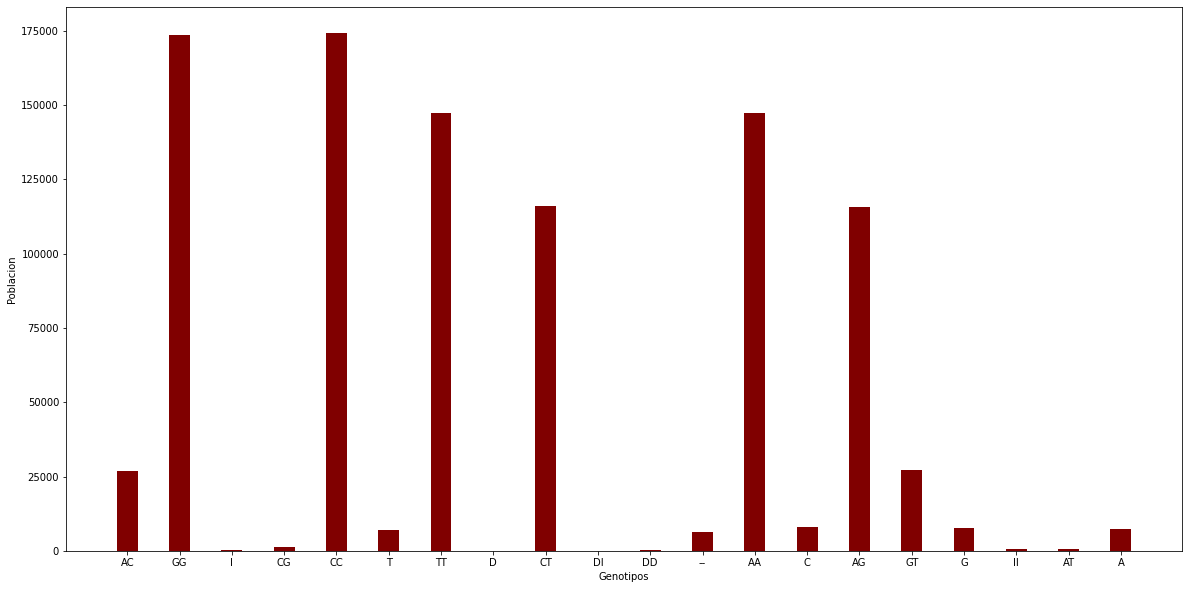

In [5]:
classes = list(count.keys())
values = list(count.values())

fig = plt.figure(figsize = (20, 10))
plt.bar(classes, values, color ='maroon', width = 0.4) 
plt.xlabel("Genotipos") 
plt.ylabel("Poblacion")
plt.show()

Como ya tenemos el conjunto de datos ya podemos iniciar la construcción de la red

In [8]:
# creación del modelo

class Model(nn.Module):

  def __init__(self, input_size, output_size):
    super().__init__()
    self.h1 = nn.Linear(input_size, 50)
    self.h2 = nn.ReLU()
    self.h3 = nn.Linear(50, 100)
    self.h4 = nn.ReLU()
    self.h5 = nn.Linear(100, output_size)
    self.h6 = nn.Dropout(0.5)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.h1(x)
    x = self.h2(x)
    x = self.h3(x)
    x = self.h4(x)
    x = self.h5(x)
    x = self.h6(x)
    x = self.softmax(x)
    return x

x_train_tensor = pt.from_numpy(x_train.astype(np.float32))
x_test_tensor = pt.from_numpy(x_test.astype(np.float32))
y_train_tensor = pt.squeeze(pt.from_numpy(y_train).float())
y_test_tensor = pt.squeeze(pt.from_numpy(y_test).float())
model = Model(x_train_tensor.shape[1], y_train_tensor.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = pt.optim.SGD(model.parameters(), lr=1e-1)

def calculate_accuracy(y_true, y_pred):
  return (y_true == y_pred).float().sum() / len(y_true)

for epoch in range(1000):
  y_pred = model(x_train_tensor)
  y_pred = pt.squeeze(y_pred)
  train_loss = criterion(y_pred, y_train_tensor)

  if epoch % 100 == 0:
    train_acc = calculate_accuracy(y_train_tensor, y_pred)
    y_test_pred = model(x_test_tensor)
    y_test_pred = pt.squeeze(y_test_pred)
    test_loss = criterion(y_test_pred, y_test_tensor)
    test_acc = calculate_accuracy(y_test_tensor, y_test_pred)
    print(f'''epoch {epoch} 
            Train set - loss: {train_loss}, accuracy: {train_acc} 
            Test  set - loss: {test_loss}, accuracy: {test_acc}''')
    
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

epoch 0 
            Train set - loss: 0.7206419706344604, accuracy: 18.108821868896484 
            Test  set - loss: 0.7209431529045105, accuracy: 18.09599494934082
epoch 100 
            Train set - loss: 0.7176095843315125, accuracy: 18.20943832397461 
            Test  set - loss: 0.7186326384544373, accuracy: 18.166290283203125
epoch 200 
            Train set - loss: 0.718075692653656, accuracy: 18.138328552246094 
            Test  set - loss: 0.7192064523696899, accuracy: 18.084985733032227
epoch 300 
            Train set - loss: 0.7170226573944092, accuracy: 18.11128807067871 
            Test  set - loss: 0.7183912992477417, accuracy: 18.06536865234375
epoch 400 
            Train set - loss: 0.716672956943512, accuracy: 18.119251251220703 
            Test  set - loss: 0.717851459980011, accuracy: 18.076061248779297
epoch 500 
            Train set - loss: 0.716192901134491, accuracy: 18.049291610717773 
            Test  set - loss: 0.7174742221832275, accuracy: 18.006509